In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import sklearn
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd  
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
positive = pd.read_csv("/kaggle/input/succinylation/Succinylation_pos.csv").dropna().drop_duplicates()
negative = pd.read_csv("/kaggle/input/succinylation/Succinylation_neg.csv").dropna().drop_duplicates()

#Filter data
positive = positive[positive['protein_seq'].str.len() < 5000]
negative = negative[negative['protein_seq'].str.len() < 5000]

print(f"Positive shape: {positive.shape}")
print(f"Negative shape: {negative.shape}")
positive['actual_label'] = 1
negative['actual_label'] = 0

datasets = positive.append(negative, ignore_index=True)
# print(datasets)
print(datasets.head(2))
print("-"*100)
print(datasets.tail(2))

Positive shape: (4844, 4)
Negative shape: (5183, 4)
  protein_id protein_name  protein_position  \
0     P93206  14331_SOLLC               130   
1     Q6ZKC0  14333_ORYSJ                70   

                                         protein_seq  actual_label  
0  MALPENLTREQCLYLAKLAEQAERYEEMVKFMDKLVIGSGSSELTV...             1  
1  MSREENVYMAKLAEQAERYEEMVEYMEKVAKTVDVEELTVEERNLL...             1  
----------------------------------------------------------------------------------------------------
      protein_id protein_name  protein_position  \
10025     Q3UHH1  ZSWM8_MOUSE              1249   
10026     P32527   ZUO1_YEAST                21   

                                             protein_seq  actual_label  
10025  MELMFAEWEDGERFSFEDSDRFEEDSLCSFISEAESLCQNWRGWRK...             0  
10026  MFSLPTLTSDITVEVNSSATKTPFVRRPVEPVGKFFLQHAQRTLRN...             0  


In [3]:
datasets.shape

(10027, 5)

In [4]:
train_sample, test_sample = train_test_split(datasets, test_size=.05, random_state = 42)

In [5]:
print(f"test_sample: {test_sample.shape}")
print(f"train_sample: {train_sample.shape}")

test_sample: (502, 5)
train_sample: (9525, 5)


# For ProtBert Model


In [75]:
data = np.load("/kaggle/input/databert2131/data31_bert.npz")
positive = data["positive"]
negative = data["negative"]

Y_positive = np.ones(positive.shape[0])
Y_negative = np.zeros(negative.shape[0])
X = np.concatenate((positive, negative), axis=0)
Y = np.concatenate((Y_positive, Y_negative), axis=0)
print(X.shape)

(10027, 31, 1024)


In [76]:
modelBert = tf.keras.models.load_model("/kaggle/input/all-model/bert_win31_acc.h5")
modelBert.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 31, 64)            65600     
                                                                 
 max_pooling1d_70 (MaxPoolin  (None, 15, 64)           0         
 g1D)                                                            
                                                                 
 dropout_105 (Dropout)       (None, 15, 64)            0         
                                                                 
 conv1d_71 (Conv1D)          (None, 15, 128)           8320      
                                                                 
 max_pooling1d_71 (MaxPoolin  (None, 7, 128)           0         
 g1D)                                                            
                                                                 
 dropout_106 (Dropout)       (None, 7, 128)          

In [85]:
X_train, X_t, Y_train, Y_t = train_test_split( X, Y, test_size=0.05, random_state=42)
print(f"test_sample: {X_t.shape}")
print(f"train_sample: {X_train.shape}")

test_sample: (502, 31, 1024)
train_sample: (9525, 31, 1024)


In [86]:
y_true= Y_t
X_te = X_t
y_pred = (modelBert.predict(X_te) > 0.5).astype(int)
mcc =sklearn.metrics.matthews_corrcoef(y_true, y_pred)
print(mcc)

16/16 [==============================] - 0s 5ms/step
0.5031934499789418


In [79]:
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print("f1 score: ",f1_score)
acc = sklearn.metrics.accuracy_score(y_true, y_pred)
print("acc: ", acc)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
print("confusion matrix: ",confusion_matrix)

f1 score:  0.7359667359667359
acc:  0.7470119521912351
confusion matrix:  [[198  43]
 [ 84 177]]


In [74]:
test_sample['predicted_label'] = y_pred.reshape(-1)
test_sample['is_correct_label?'] = (y_pred.reshape(-1) == y_true.reshape(-1)).astype(int)

In [75]:
test_sample.head()

,protein_id,protein_name,protein_position,protein_seq,actual_label,predicted_label,is_correct_label?
3312,Q8BMF4,ODP2_MOUSE,391,MWRVCARRARSAVPRDGFRARWAALKEGPGAPCGSPRIGPAAVRCG...,1,1,1
9079,Q87PB5,Q87PB5_VIBPA,70,MTARENVVPVLLEKVYQLIQDKLELSHQTLVTKLAQHLFSNIADDD...,0,0,1
6129,P17555,CAP_YEAST,509,MPDSKYTMQGYNLVKLLKRLEEATARLEDVTIYQEGYIQNKLEASK...,0,0,1
1147,P63284,CLPB_ECOLI,163,MRLDRLTNKFQLALADAQSLALGHDNQFIEPLHLMSALLNQEGGSV...,1,1,1
7105,P77399,FADJ_ECOLI,578,MEMTSAFTLNVRLDNIAVITIDVPGEKMNTLKAEFASQVRAIIKQL...,0,1,0


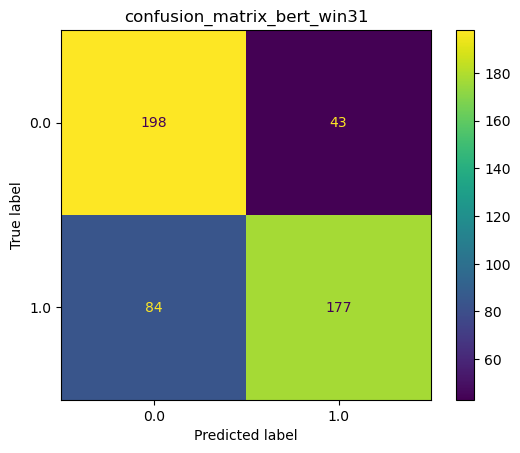

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
f = disp
plt.title("confusion_matrix_bert_win31")
plt.savefig("/kaggle/working/confusion_matrix_bert_win31.png")
plt.show()

In [80]:
test_sample.to_csv("/kaggle/working/model_test_bert_win31.csv",index=False)

16/16 [==============================] - 0s 5ms/step


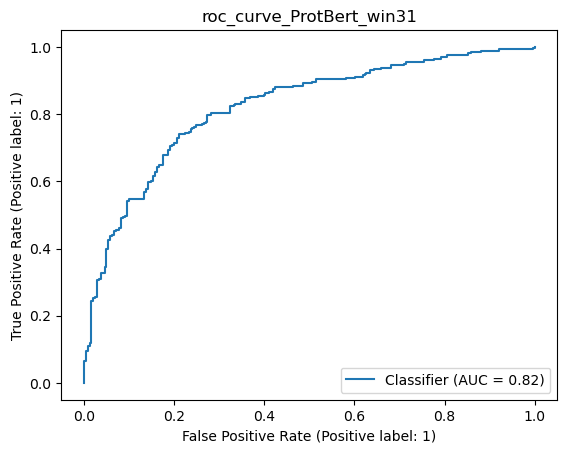

In [82]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)
disp = RocCurveDisplay.from_predictions(y_true, modelBert.predict(X_te), ax= ax)
f = disp
plt.title("roc_curve_ProtBert_win31")
plt.savefig("/kaggle/working/roc_curve_bert_win31.png")
plt.show()


16/16 [==============================] - 0s 5ms/step


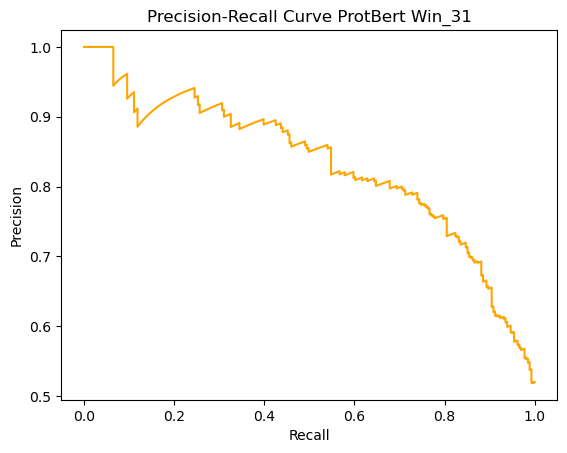

In [99]:
from sklearn.metrics import precision_recall_curve
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, modelBert.predict(X_te))

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

#add axis labels to plot
ax.set_title('Precision-Recall Curve ProtBert Win_31')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig("/kaggle/working/pr_curve_bert_win31.png")
plt.show()

# For ProtT5 Model

In [100]:
data = np.load("/kaggle/input/data31-t5/data31.npz")
positive = data["positive"]
negative = data["negative"]

Y_positive = np.ones(positive.shape[0])
Y_negative = np.zeros(negative.shape[0])
X = np.concatenate((positive, negative), axis=0)
Y = np.concatenate((Y_positive, Y_negative), axis=0)
print(X.shape)

(10027, 31, 1024)


In [101]:
modelBert = tf.keras.models.load_model("/kaggle/input/all-model/t5_win31_acc.h5")
modelBert.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 31, 64)            65600     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 15, 64)           0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 15, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 15, 128)           8320      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 7, 128)           0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 7, 128)           

In [102]:
X_train, X_t, Y_train, Y_t = train_test_split( X, Y, test_size=0.05, random_state=42)
print(f"test_sample: {X_t.shape}")
print(f"train_sample: {X_train.shape}")

test_sample: (502, 31, 1024)
train_sample: (9525, 31, 1024)


In [103]:
y_true= Y_t
X_te = X_t
y_pred = (modelBert.predict(X_te) > 0.5).astype(int)
mcc =sklearn.metrics.matthews_corrcoef(y_true, y_pred)
print(mcc)

16/16 [==============================] - 0s 5ms/step
0.5807836290330954


In [104]:
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print("f1 score: ",f1_score)
acc = sklearn.metrics.accuracy_score(y_true, y_pred)
print("acc: ", acc)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
print("confusion matrix: ",confusion_matrix)

f1 score:  0.8022598870056497
acc:  0.7908366533864541
confusion matrix:  [[184  57]
 [ 48 213]]


In [15]:
test_sample['predicted_label'] = y_pred.reshape(-1)
test_sample['is_correct_label?'] = (y_pred.reshape(-1) == y_true.reshape(-1)).astype(int)

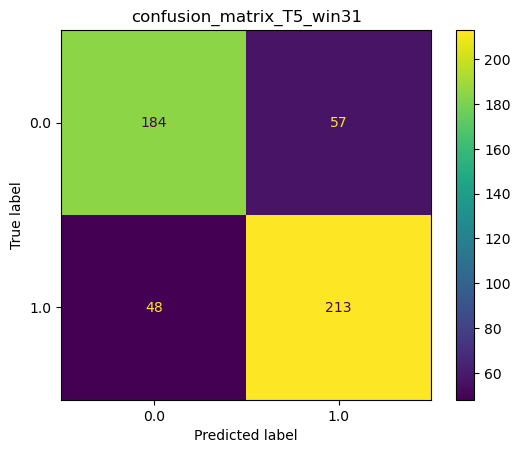

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
f = disp
plt.title("confusion_matrix_T5_win31")
plt.savefig("/kaggle/working/confusion_matrix_T5_win31.png")
plt.show()

In [17]:
test_sample.to_csv("/kaggle/working/model_test_T5_win31.csv",index=False)

16/16 [==============================] - 0s 5ms/step


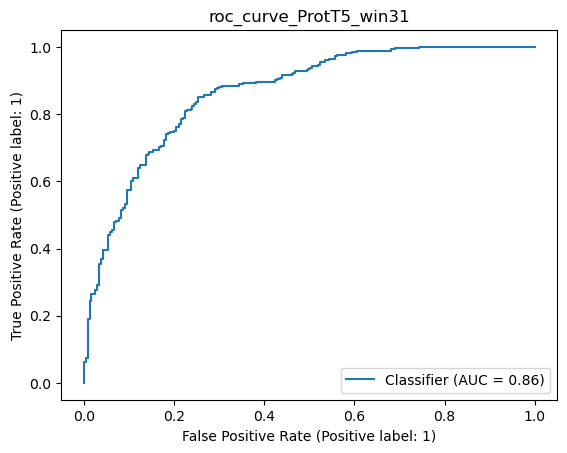

In [106]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)
disp = RocCurveDisplay.from_predictions(y_true, modelBert.predict(X_te), ax= ax)
f = disp
plt.title("roc_curve_ProtT5_win31")
plt.savefig("/kaggle/working/roc_curve_T5_win31.png")
plt.show()


16/16 [==============================] - 0s 5ms/step


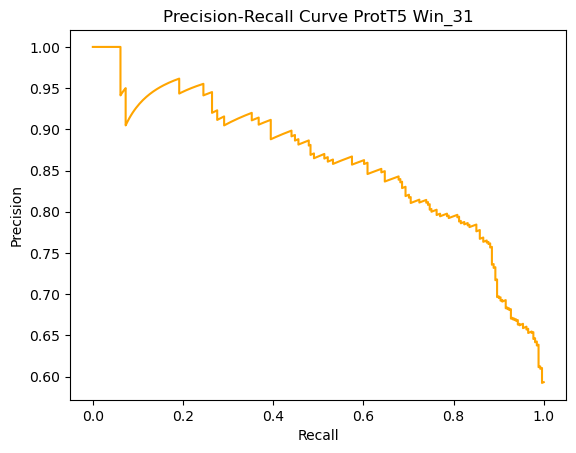

In [107]:
from sklearn.metrics import precision_recall_curve
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, modelBert.predict(X_te))

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

#add axis labels to plot
ax.set_title('Precision-Recall Curve ProtT5 Win_31')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig("/kaggle/working/pr_curve_ProtT5_win31.png")
plt.show()

# For combined T5+Protbert

In [108]:
data = np.load("/kaggle/input/data31-t5/data31.npz")
positive = data["positive"]
negative = data["negative"]

# Y_positive = np.ones(positive.shape[0])
# Y_negative = np.zeros(negative.shape[0])
X_T5 = np.concatenate((positive, negative), axis=0)

data = np.load("/kaggle/input/databert2131/data31_bert.npz")
positive = data["positive"]
negative = data["negative"]

Y_positive = np.ones(positive.shape[0])
Y_negative = np.zeros(negative.shape[0])
X_bert = np.concatenate((positive, negative), axis=0)

X = np.concatenate((X_T5, X_bert), axis=-1)
Y = np.concatenate((Y_positive, Y_negative), axis=0)
print(X.shape)

(10027, 31, 2048)


In [109]:
modelBert = tf.keras.models.load_model("/kaggle/input/all-model/comb_win31_acc.h5")
modelBert.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 31, 64)            131136    
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 15, 64)           0         
 g1D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 15, 64)            0         
                                                                 
 conv1d_19 (Conv1D)          (None, 15, 128)           8320      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 7, 128)           0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 7, 128)           

In [110]:
X_train, X_t, Y_train, Y_t = train_test_split( X, Y, test_size=0.05, random_state=42)
print(f"test_sample: {X_t.shape}")
print(f"train_sample: {X_train.shape}")

test_sample: (502, 31, 2048)
train_sample: (9525, 31, 2048)


In [111]:
y_true= Y_t
X_te = X_t
y_pred = (modelBert.predict(X_te) > 0.5).astype(int)
mcc =sklearn.metrics.matthews_corrcoef(y_true, y_pred)
print(mcc)

16/16 [==============================] - 0s 8ms/step
0.5768052048539699


In [112]:
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print("f1 score: ",f1_score)
acc = sklearn.metrics.accuracy_score(y_true, y_pred)
print("acc: ", acc)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
print("confusion matrix: ",confusion_matrix)

f1 score:  0.8007518796992481
acc:  0.7888446215139442
confusion matrix:  [[183  58]
 [ 48 213]]


In [113]:
test_sample['predicted_label'] = y_pred.reshape(-1)
test_sample['is_correct_label?'] = (y_pred.reshape(-1) == y_true.reshape(-1)).astype(int)

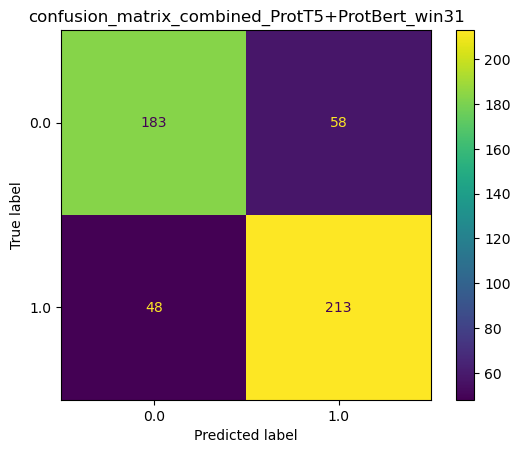

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
f = disp
plt.title("confusion_matrix_combined_ProtT5+ProtBert_win31")
plt.savefig("/kaggle/working/confusion_matrix_combined_ProtT5+ProtBert_win31.png")
plt.show()

In [28]:
test_sample.to_csv("/kaggle/working/model_test_combined_ProtT5+ProtBert_win31.csv",index=False)

In [31]:
test_sample.head()

,protein_id,protein_name,protein_position,protein_seq,actual_label,predicted_label,is_correct_label?
3312,Q8BMF4,ODP2_MOUSE,391,MWRVCARRARSAVPRDGFRARWAALKEGPGAPCGSPRIGPAAVRCG...,1,1,1
9079,Q87PB5,Q87PB5_VIBPA,70,MTARENVVPVLLEKVYQLIQDKLELSHQTLVTKLAQHLFSNIADDD...,0,0,1
6129,P17555,CAP_YEAST,509,MPDSKYTMQGYNLVKLLKRLEEATARLEDVTIYQEGYIQNKLEASK...,0,0,1
1147,P63284,CLPB_ECOLI,163,MRLDRLTNKFQLALADAQSLALGHDNQFIEPLHLMSALLNQEGGSV...,1,1,1
7105,P77399,FADJ_ECOLI,578,MEMTSAFTLNVRLDNIAVITIDVPGEKMNTLKAEFASQVRAIIKQL...,0,1,0


16/16 [==============================] - 0s 8ms/step


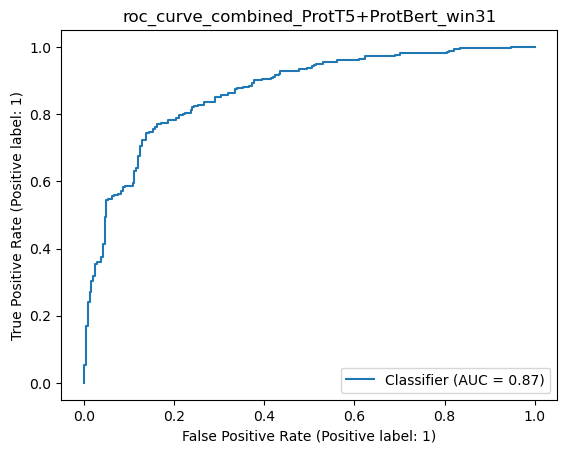

In [115]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)
disp = RocCurveDisplay.from_predictions(y_true, modelBert.predict(X_te), ax= ax)
f = disp
plt.title("roc_curve_combined_ProtT5+ProtBert_win31")
plt.savefig("/kaggle/working/roc_curve_combined_ProtT5+ProtBert_win31.png")
plt.show()


16/16 [==============================] - 0s 7ms/step


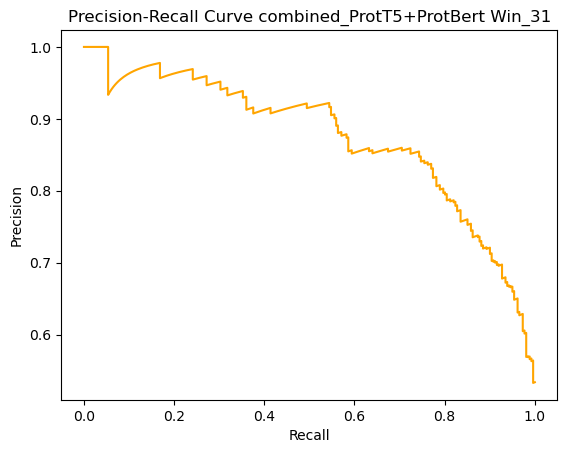

In [116]:
from sklearn.metrics import precision_recall_curve
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, modelBert.predict(X_te))

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

#add axis labels to plot
ax.set_title('Precision-Recall Curve combined_ProtT5+ProtBert Win_31')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig("/kaggle/working/pr_curve_combined_ProtT5+ProtBert_win31.png")
plt.show()

# For meta classifier

In [18]:
data_bert = np.load('/kaggle/input/databert2131/data31_bert.npz')
positive_bert = data_bert['positive']
negative_bert = data_bert['negative']
data_T5 = np.load('/kaggle/input/data31-t5/data31.npz')
positive_T5 = data_T5['positive']
negative_T5 = data_T5['negative']
print(positive_bert.shape, positive_T5.shape)

positive_dataset = np.hstack((positive_bert, positive_T5))
negative_dataset = np.hstack((negative_bert, negative_T5))
print(negative_dataset.shape[0])
X = np.vstack([positive_dataset, negative_dataset]) 
p_label = np.ones(positive_dataset.shape[0])
n_label = np.zeros(negative_dataset.shape[0])
Y = np.append(p_label,n_label,axis=0)
print(X.shape)

(4844, 31, 1024) (4844, 31, 1024)
5183
(10027, 62, 1024)


In [19]:
MetaCombinedModel = tf.keras.models.load_model("/kaggle/input/meta-combined-31/meta_combine_win31_acc.h5", compile = False)
MetaCombinedModel.summary()

Model: "merged_layers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv1d_36_input (InputLayer)   [(None, 31, 1024)]   0           []                               
                                                                                                  
 conv1d_38_input (InputLayer)   [(None, 31, 1024)]   0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 31, 144)      147600      ['conv1d_36_input[0][0]']        
                                                                                                  
 conv1d_38 (Conv1D)             (None, 31, 144)      147600      ['conv1d_38_input[0][0]']        
                                                                                      

In [20]:
X_train, X_t, Y_train, Y_t = train_test_split( X, Y, test_size=0.05, random_state=42)
print(f"test_sample: {X_t.shape}")
print(f"train_sample: {X_train.shape}")

test_sample: (502, 62, 1024)
train_sample: (9525, 62, 1024)


In [24]:
#Threshold testing

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

y_true  = Y_t
X_te = X_t
thresholds = np.arange(0,1,0.001)
probs = MetaCombinedModel.predict([X_te[:, :31], X_te[:, 31:]])
scores = [sklearn.metrics.f1_score(y_true, to_labels(probs,t)) for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

# y_pred = (MetaCombinedModel.predict([X_te[:, :21], X_te[:, 21:]]) > 0.5).astype(int)

16/16 [==============================] - 0s 11ms/step
Threshold=0.380, F-Score=0.83451


In [35]:
y_true= Y_t
X_te = X_t
y_pred = (MetaCombinedModel.predict([X_te[:, :31], X_te[:, 31:]]) > 0.38).astype(int)
mcc =sklearn.metrics.matthews_corrcoef(y_true, y_pred)
print(mcc)

16/16 [==============================] - 0s 11ms/step
0.6330561281250139


In [36]:
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print("f1 score: ",f1_score)
acc = sklearn.metrics.accuracy_score(y_true, y_pred)
print("acc: ", acc)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
print("confusion matrix: ",confusion_matrix)

f1 score:  0.8345070422535212
acc:  0.8127490039840638
confusion matrix:  [[171  70]
 [ 24 237]]


In [47]:
test_sample['predicted_label'] = y_pred.reshape(-1)
test_sample['is_correct_label?'] = (y_pred.reshape(-1) == y_true.reshape(-1)).astype(int)

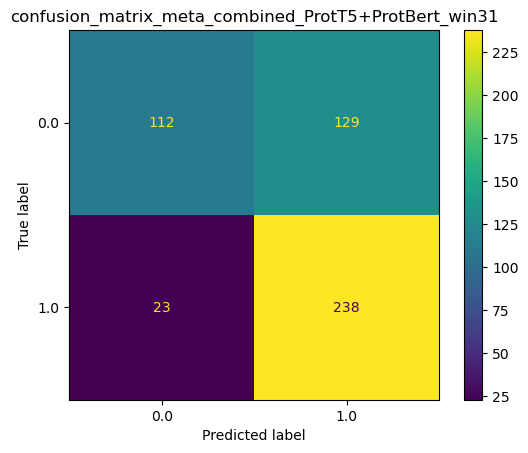

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
f = disp
plt.title("confusion_matrix_meta_combined_ProtT5+ProtBert_win31")
plt.savefig("/kaggle/working/meta_confusion_matrix_combined_ProtT5+ProtBert_win31.png")
plt.show()

,protein_id,protein_name,protein_position,protein_seq,actual_label,predicted_label,is_correct_label?
3312,Q8BMF4,ODP2_MOUSE,391,MWRVCARRARSAVPRDGFRARWAALKEGPGAPCGSPRIGPAAVRCG...,1,1,1
9079,Q87PB5,Q87PB5_VIBPA,70,MTARENVVPVLLEKVYQLIQDKLELSHQTLVTKLAQHLFSNIADDD...,0,0,1
6129,P17555,CAP_YEAST,509,MPDSKYTMQGYNLVKLLKRLEEATARLEDVTIYQEGYIQNKLEASK...,0,0,1
1147,P63284,CLPB_ECOLI,163,MRLDRLTNKFQLALADAQSLALGHDNQFIEPLHLMSALLNQEGGSV...,1,1,1
7105,P77399,FADJ_ECOLI,578,MEMTSAFTLNVRLDNIAVITIDVPGEKMNTLKAEFASQVRAIIKQL...,0,0,1


In [52]:
test_sample.to_csv("/kaggle/working/model_test_meta_combined_ProtT5+ProtBert_win31.csv",index=False)

16/16 [==============================] - 0s 12ms/step


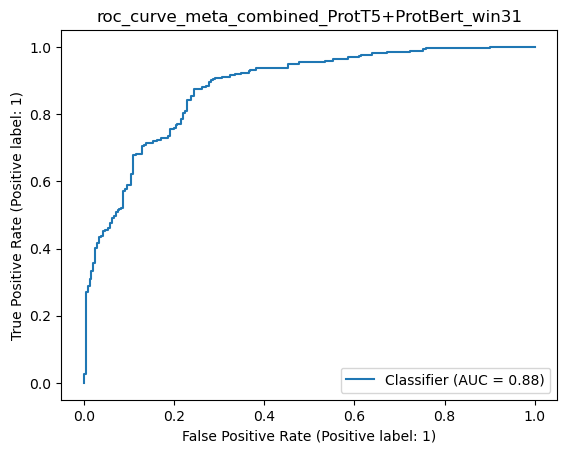

In [123]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)
disp = RocCurveDisplay.from_predictions(y_true, MetaCombinedModel.predict([X_te[:, :31], X_te[:, 31:]]), ax= ax)
f = disp
plt.title("roc_curve_meta_combined_ProtT5+ProtBert_win31")
plt.savefig("/kaggle/working/roc_curve_meta_combined_ProtT5+ProtBert_win31.png")
plt.show()


16/16 [==============================] - 0s 11ms/step


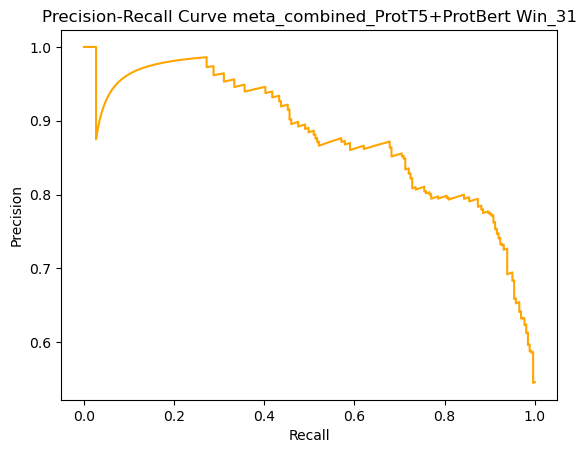

In [124]:
from sklearn.metrics import precision_recall_curve
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true,MetaCombinedModel.predict([X_te[:, :31], X_te[:, 31:]]))

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

#add axis labels to plot
ax.set_title('Precision-Recall Curve meta_combined_ProtT5+ProtBert Win_31')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig("/kaggle/working/pr_curve_meta_combined_ProtT5+ProtBert_win31.png")
plt.show()

# Independent testing

In [3]:
T5Model = tf.keras.models.load_model("/kaggle/input/all-model/t5_win31_acc.h5", compile = False)
T5Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 31, 64)            65600     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 15, 64)           0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 15, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 15, 128)           8320      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 7, 128)           0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 7, 128)           

In [4]:
negative_test = np.load("/kaggle/input/independent-test-set-t5/test_negative0.npz")["arr_0"]
id_negative = np.load("/kaggle/input/independent-test-set-t5/negative0.npz")["arr_0"]
positive = np.load("/kaggle/input/independent-test-set-t5/test_positive0.npz")["arr_0"]
negative = np.concatenate((negative_test, id_negative), axis=0)

In [5]:
print(negative.shape)
print(positive.shape)

(437, 31, 1024)
(253, 31, 1024)


In [6]:
X = np.concatenate((positive, negative), axis = 0)
Y = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])), axis = 0)
print(X.shape)
print(Y.shape)

(690, 31, 1024)
(690,)


In [19]:
y_pred = (T5Model.predict(X) > 0.44).astype(int)
mcc =sklearn.metrics.matthews_corrcoef(Y, y_pred)
print(mcc)

22/22 [==============================] - 0s 7ms/step
0.347695324642419


In [20]:
f1_score = sklearn.metrics.f1_score(Y, y_pred)
print("f1 score: ",f1_score)
acc = sklearn.metrics.accuracy_score(Y, y_pred)
print("acc: ", acc)
confusion_matrix = sklearn.metrics.confusion_matrix(Y, y_pred)
print("confusion matrix: ",confusion_matrix)

f1 score:  0.6232558139534883
acc:  0.6478260869565218
confusion matrix:  [[246 191]
 [ 52 201]]


22/22 [==============================] - 0s 5ms/step


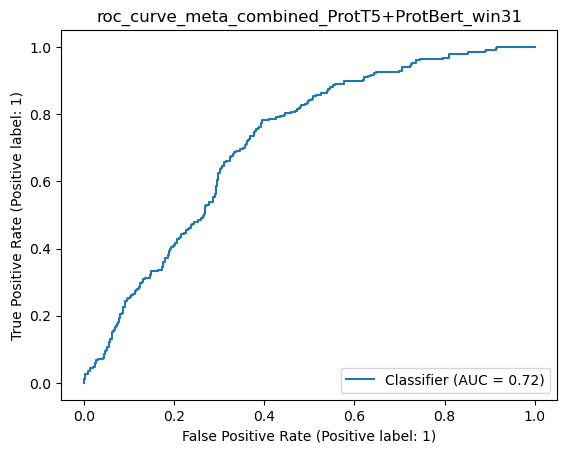

In [21]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)
disp = RocCurveDisplay.from_predictions(Y, T5Model.predict(X), ax= ax)
f = disp
plt.title("roc_curve_meta_combined_ProtT5+ProtBert_win31")
plt.savefig("/kaggle/working/roc_curve_meta_combined_ProtT5+ProtBert_win31.png")
plt.show()
